# DeepGhostBusters: Performance Evaluation

In this notebook we load the Mask R-CNN model (DeepGhostBuster) we trained in a separate notebook, and we perfrorm and number of tests in order to quantify its ability to detect ghosting artifacts.

We use both conventional object detection metrics (such as the mean Average Precision - mAP) and custom metrics, such as the CCD-based Precision and Recall; these evaluate the performance of DeepGhostBusters in a less granular level that is more appropriate for problem at hand and allow the comparison between DeepGhosBuster and the ray tracing algorithm.

We discuss these metrics in detail below.

In [1]:
# Import basic packages 
import numpy as np 
import scipy as scipy 
import os
import sys
import json
import datetime
from PIL import Image
import skimage.draw
import numpy.ma as ma
import imageio
import cv2


#import tensorflow 1
%tensorflow_version 1.x
import keras

# Scikit-learn for evaluation metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# Colab in order to be able to download files
from google.colab import files

# Matplotlib plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

TensorFlow 1.x selected.


Using TensorFlow backend.


Un-comment and run the following lines in order to install packages that 
allow LaTeX to be used in matplotlib (process of labels).

In [2]:
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super

In [3]:
# Import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd drive/MyDrive/
#!pwd
!pip install fitsio

/content/drive/MyDrive
     |████████████████████████████████| 5.0MB 12.4MB/s 
  Created wheel for fitsio: filename=fitsio-1.1.4-cp37-cp37m-linux_x86_64.whl size=1778748 sha256=a982402273a3f19d0101e4d3d46ce3c914c5dfcc74f7f99844532a4c9aced540
  Stored in directory: /root/.cache/pip/wheels/22/41/8e/36c7c16edc7fd0ecc4aa3064c565d1b62152f2ff58ac567266
Successfully built fitsio


**Import Mask R-CNN**


In [5]:
# To find the path for Mask_RCNN
sys.path.insert(1, 'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Import Field-of-View Geometry 
# this is in order to get the limits of the CCDs
from run import fov_geometry

In [6]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "MyDrive/Mask_RCNN/logs")

# Local path to trained weights file - Mask R-CNN
# This can change and we can use trained of more shallow 
GHOST_MODEL_PATH = os.path.join(ROOT_DIR, "MyDrive/Mask_RCNN/mask_rcnn_Ghosts.h5")

In [7]:
# Notebook preferences
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Configurations

Here we create a class that overrides some of the Mask R-CNN model configurations we have to change.

In [8]:
# This class can be further edited

class GhostsConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Type"
 
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + three ghost categories

    # Learning rate - DEFAULT = 0.004
    LEARNING_RATE = 0.004

    # How to resize the image
    # Use "none" if you don't want to resize
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Maximum number of ground truth instances (objects) in one image
    MAX_GT_INSTANCES = 100
    DETECTION_MAX_INSTANCES = 100

 
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 150
 
    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.8

config = GhostsConfig()

# Uncomment the following line, if you want to see the values of all the 
# configuration parameters (including the default values)
#config.display() 

# =====================================================================
# =====================================================================
class InferenceConfig(GhostsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights
print("Loading weights from ", GHOST_MODEL_PATH)
model.load_weights(GHOST_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/MyDrive/Mask_RCNN/mask_rcnn_Ghosts.h5


**One detection example:**

In [9]:
# Directory of images to run detection on
IMAGE_DIR = "Plots"
# Load a random image from the images folder
file_names = 'Ghost_Img.jpg'
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names))

Processing 1 images
image                    shape: (400, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



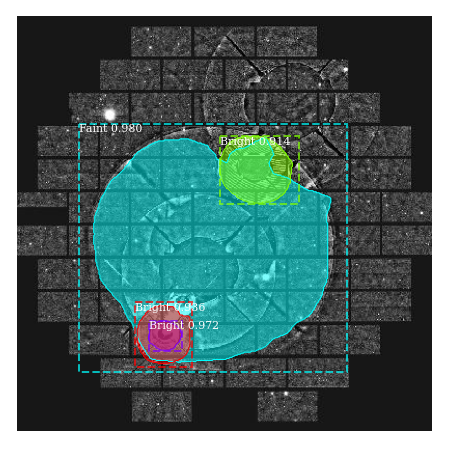

In [10]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           ['Rays','Bright','Faint'], r['scores'], ax=get_ax())

## Part I: CCD-based Precision, Recall, and F1 score

In the following section we will consider some commonly used object detection evaluation metrics; in the present section we would like to define some alternative metrics that we think are appropriate for the problem at hand.

The DECam focal plane consists of 62 CCDs. In each one of them a ghost may or may not be present. Current algorithms that are used to track and remove ghosting artifacts flag bad CCDs; thus if we want to compare their performance to a Mask R-CNN based approach developing metrics that are based on whether a CCD contains a ghosting artifact or not. 

Furthermore, given the challenges of this problem (overlapping sources, borders of objects not always well defined) assesing the performance at a less granualr level (complared, for example, to the overlap of the predicted and true mask of an object) is more appropriate.



---



---


Let's assume that we have a batch of $M$ images, each one containing 62 CCDs, so $N = 62\times M$ CCDs in total. These $M$ images can be those in the training, validation, and test sets, for example.

Let's  now define as ``positives`` those CCDs containing a ghost and ``negatives`` those that do not. Note that we can have such a definition for each type of ghosts separately or for all types of ghosts, combined (i.e. a CCD containing any ghost or a CCD containing a specific type of ghosts, e.g. "Rays"). 

We can then define the following:

- True Positives, $N^{TP}$: Number of CCDs predicted to contain a ghost that actually contain a ghost.

- True Negatives, $N^{TN}$: Number of CCDs predicted not to contain a ghost and actually do not contain one (ground truth).

- False Postives, $N^{FP}$: Number of CCDs predicted to contain a ghost that do not actually contain one.

- False Negatives, $N^{FN}$: Number of CCDs predicted not to contain a ghost that actually contain one.

Then, based on these we can define the *CCD*-based Precision (purity), Recall (completeness), and F1 scores as:



\begin{equation}
Precision_{\scriptsize{CCD}} = \frac{N^{TP}}{N^{TP}+N^{FP}}
\end{equation}

\\

\begin{equation}
Recall_{\scriptsize{CCD}} = \frac{N^{TP}}{N^{TP}+N^{FN}}
\end{equation}

\\
The $F1$ score is the harmonic mean of precision and recall:
\begin{equation}
F1 = 2\frac{Precision_{\scriptsize{CCD}}\cdot Recall_{\scriptsize{CCD}}}{Precision_{\scriptsize{CCD}}+Recall_{\scriptsize{CCD}}}
\end{equation}

\\
A final, but ***very important*** note: all these definitions above depend on the concept of a CCD "containing" a ghost, or not. But how do we define that?



**Import CCD coordinates**

`Name` of CCDs is in the range 1-62

Then we have the min and max (pixel) coordinates for each one of these CCDs

In [11]:
# Get CCDs
ccds = np.asarray(fov_geometry(release='y1a1',size=[400,400]))

print(np.shape(ccds))

name = ccds[:,0]
x_min = ccds[:,1]
y_min = ccds[:,2]
x_max = ccds[:,3]
y_max = ccds[:,4]

x_min_pr = x_min + (x_min-200)*38.5*0.0025
x_max_pr = x_max + (x_max-200)*38.5*0.0025

(62, 5)


Let's esimate the dimensions (in pixels) of a single CCD.

Let's find the difference between the `y_max` and `y_min` and also `x_max` and `x_min`.

That way we can define are thersholds (as percentages) for defining that a CCD "contains" a ghost or not.

In [12]:
print(np.mean(y_max-y_min))
print(np.mean(x_max_pr-x_min_pr))

# So the number of pixels within a CCD is:

print("Number of pixels within CCD:",32*60.11695)

32.0
60.116935483870954
Number of pixels within CCD: 1923.7424


First define a function that creates masks for the three types of ghost,

- Returns an $400\times 400$ mask for each type of ghost

In [13]:
# Define function that creates mask for the Ghosts
def masking(regions,n_ghosts):

  #Initialize three different masks - one for each type of ghosts
  X_mask_rays = np.zeros([400,400])
  X_mask_bright = np.zeros([400,400])
  X_mask_faint = np.zeros([400,400])

  for j in range(n_ghosts):
    regions_loc = regions[j]

    # ==========================================
    # ==========================================
    # First get ghost types
    Type_loc = regions_loc['region_attributes']['Type']

    # Get shape attributes
    shape_attrs = regions_loc['shape_attributes']

    # Get the name of the shape attribute
    name = shape_attrs['name']
    # =====================================================
    # =====================================================
    
    if (name=='polyline'):
      rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
      a = (rr<400)&(cc<400)
    elif (name=='polygon'):
      rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
      a = (rr<400)&(cc<400)
    elif (name=='rect'):
      rr, cc = skimage.draw.rectangle(start=(shape_attrs['y'], shape_attrs['x']),
                              extent=(shape_attrs['height'],shape_attrs['width']))
      a = (rr<400)&(cc<400)
    elif (name=='circle'):
      rr, cc = skimage.draw.circle(shape_attrs['cy'],shape_attrs['cx'],shape_attrs['r'])
      a = (rr<400)&(cc<400)
    elif (name=='ellipse'): 
      rr, cc = skimage.draw.ellipse(shape_attrs['cy'],shape_attrs['cx'],
                                      shape_attrs['ry'],shape_attrs['rx'],
                                      shape=None,rotation=-shape_attrs['theta'])
      a = (rr<400)&(cc<400)
    # ========================================================
    # ========================================================
    if (Type_loc=='Rays'):
      X_mask_rays[rr[a], cc[a]] = 1
    elif (Type_loc=='Bright'):
      X_mask_bright[rr[a], cc[a]] = 1
    elif (Type_loc=='Faint'):
      X_mask_faint[rr[a], cc[a]] = 1

  # ===========================================================
  # ===========================================================
  X_mask_rays = ma.masked_where(X_mask_rays<1, X_mask_rays) 
  X_mask_bright = ma.masked_where(X_mask_bright<1, X_mask_bright)
  X_mask_faint = ma.masked_where(X_mask_faint<1, X_mask_faint)

  return X_mask_rays, X_mask_bright, X_mask_faint

Now we write a function that gets a dataset, a percentage and returns evaluation metrics

In [22]:
# General path for the directory where Training/Validation/Test sets are
dataset_dir = os.path.join(ROOT_DIR, "MyDrive/Dataset")

def evaluation_CCD(subset, percentage):
  """
  Inputs:

  Outputs:
  """

  # Check that it is one of the Training, Validation or Test sets
  assert subset in ["Training_set", "Validation_set", "Test_set"]

  # Find directorty of the subset
  dataset_loc = os.path.join(dataset_dir, subset)

  # Load annotations
  annotations = json.load(open(os.path.join(dataset_loc, "via_region_data.json")))
  
  # ==========================================
  # Print the number of images
  n_img = len(annotations)
  #print("Number of images in the set:", n_img)


  # ============================================================
  # Set CCD area threshold (in pixels) that defines what is considered 
  # to contain a ghost - it should be *at least* one pixel

  n_pix_thres = max(1,32.0*60.1169*percentage)

  # ===========================================================
  # ===========================================================
  # Create empty arrays for the the ground truth label for each image and each CCD
  True_CCDs_rays = np.zeros([n_img,62]) # For rays
  True_CCDs_bright = np.zeros([n_img,62]) # For bright
  True_CCDs_faint = np.zeros([n_img,62]) # For faint

  # Create empty arrays for the predictions, for each image and each CCD
  Pred_CCDs_rays = np.zeros([n_img,62]) # For rays
  Pred_CCDs_bright = np.zeros([n_img,62]) # For bright
  Pred_CCDs_faint = np.zeros([n_img,62]) # For faint

  # Now we should populate both the True and Predicted arrays
  # Work for each one of the images
  for i in range(n_img):
    # Get the annotations of the i-th image
    img_annotations = annotations[i]

    # === Filename and exposure number ========================
    
    # Get filename
    filename = img_annotations['filename']
    
    # Get exposure number - split the string
    expnum_loc = int(filename[13:19])
    
    # =========================================================
    # =========================================================
    # ============== For ground truth first ===================

    # Start by getting the masks

    # Get regions - pretty much the description of the annotations
    regions = img_annotations['regions']  
    # Now get the number of ghosts
    n_ghosts = len(regions)

    # Create two dimentional array that contains 
    # the ghost masks 
    X_rays, X_bright, X_faint = masking(regions,n_ghosts)

    # ============ Find affected CCDs ===================
    for k in range(62):
      CCD_loc = k # Local number of CCD

      # For rays
      loc_mask_rays = X_rays[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
      if (np.sum(loc_mask_rays)>n_pix_thres):
        True_CCDs_rays[i,k] = 1.0
      # For bright
      loc_mask_bright = X_bright[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
      if (np.sum(loc_mask_bright)>n_pix_thres):
        True_CCDs_bright[i,k] = 1.0
      # For faint
      loc_mask_faint = X_faint[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
      if (np.sum(loc_mask_faint)>n_pix_thres):
        True_CCDs_faint[i,k] = 1.0

    # =========================================================
    # =========================================================
    # ================== For predictions now ==================

    # Get image 
    image = skimage.io.imread(os.path.join(dataset_loc, filename))

    # Run predictions
    results = model.detect([image], verbose=0)
    r = results[0]

    # Get ghosts masks - shape 400x400x(number of ghosts)
    rcnn_masks = r['masks']

    # Get the class ids of ghosts 1=Bright, 2=Faint, 3=Rays
    ghost_classes = r['class_ids']

    # =========================================================
    # Number of predicted ghosting artifacts
    n_ghosts = len(ghost_classes)

    for k in range(62):
      CCD_loc = k # Local number of CCD

      # Now run over ghosts
      for j in range(n_ghosts):

        # Get the local mask - for the j-th ghost
        X_mask_jth = rcnn_masks[:,:,j]
        # Get the type (class) of the j-th ghost 
        class_jth = ghost_classes[j]

        loc_mask = X_mask_jth[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]

        # The following can change 
        if (np.sum(loc_mask)>n_pix_thres):

          if (class_jth==1):
            Pred_CCDs_bright[i,k] = 1.
          elif (class_jth==2):
            Pred_CCDs_faint[i,k] = 1.
          elif (class_jth==3):
            Pred_CCDs_rays[i,k] = 1.
  # ============================================================================
  # ============================================================================
  # Flatten the populated arrays

  # True values
  y_rays_true = True_CCDs_rays.flatten()
  y_bright_true = True_CCDs_bright.flatten()
  y_faint_true = True_CCDs_faint.flatten()
  # Predicted values
  y_rays_pred = Pred_CCDs_rays.flatten()
  y_bright_pred = Pred_CCDs_bright.flatten()
  y_faint_pred = Pred_CCDs_faint.flatten()


  # ============================================================
  # Calculate evaluation metrics for each one of the ghost categories, separately
  
  prec_rays = precision_score(y_rays_true,y_rays_pred) #Precision, Rays
  rec_rays = recall_score(y_rays_true,y_rays_pred) # Recall, Rays
  prec_bright = precision_score(y_bright_true,y_bright_pred)#Precision, bright
  rec_bright = recall_score(y_bright_true,y_bright_pred) #Recall, bright
  prec_faint = precision_score(y_faint_true,y_faint_pred) #Precision, faint
  rec_faint = recall_score(y_faint_true,y_faint_pred) #Recall, faint

  metrics = [prec_rays,rec_rays,prec_bright,rec_bright,prec_faint,rec_faint]

  return metrics



In [31]:
perc = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

prec_ray_per = np.zeros(len(perc))
rec_ray_per = np.zeros(len(perc))



for i in range(len(perc)):
  metrics_loc = evaluation_CCD("Test_set", perc[i])

  prec_ray_per[i] = metrics_loc[0]
  rec_ray_per[i] = metrics_loc[1]

  print("Finished for percentage:",perc[i])



Number of images in the set: 300
Finished for percentage: 0
Number of images in the set: 300
Finished for percentage: 0.05
Number of images in the set: 300
Finished for percentage: 0.1
Number of images in the set: 300
Finished for percentage: 0.15
Number of images in the set: 300
Finished for percentage: 0.2
Number of images in the set: 300
Finished for percentage: 0.25
Number of images in the set: 300
Finished for percentage: 0.3
Number of images in the set: 300
Finished for percentage: 0.35
Number of images in the set: 300
Finished for percentage: 0.4
Number of images in the set: 300
Finished for percentage: 0.45
Number of images in the set: 300
Finished for percentage: 0.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

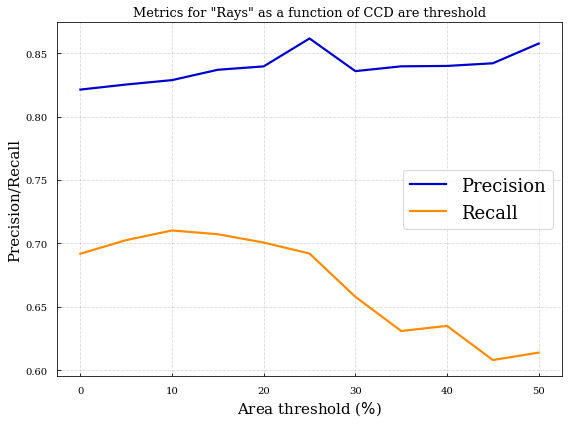

In [52]:
percen = [0,5,10,15,20,25,30,35,40,45,50]
plt.figure(figsize=(8, 6.0))

plt.plot(percen,prec_ray_per,c = 'mediumblue',linewidth=2.2,label='Precision')
plt.plot(percen,rec_ray_per,c='darkorange',linewidth=2.2,label='Recall')
plt.grid(ls='--',alpha=0.5)

plt.xlabel('Area threshold ($\%$)',fontsize=15)
plt.ylabel('Precision/Recall',fontsize=15)
plt.title('Metrics for "Rays" as a function of CCD are threshold',fontsize=13)
plt.legend(frameon=True, loc='center right', fontsize=18)
plt.tight_layout()

plt.savefig("/content/drive/My Drive/Plots/Metrics_Area.pdf")
#files.download("/content/drive/My Drive/Plots/Metrics_Area.pdf")
plt.show()

## Part II: Common object detection evaluation metrics